# Forecasting Hourly Energy Consumption with XGBoost

Notebook found at: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

In [3]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
len(pjme)

145366

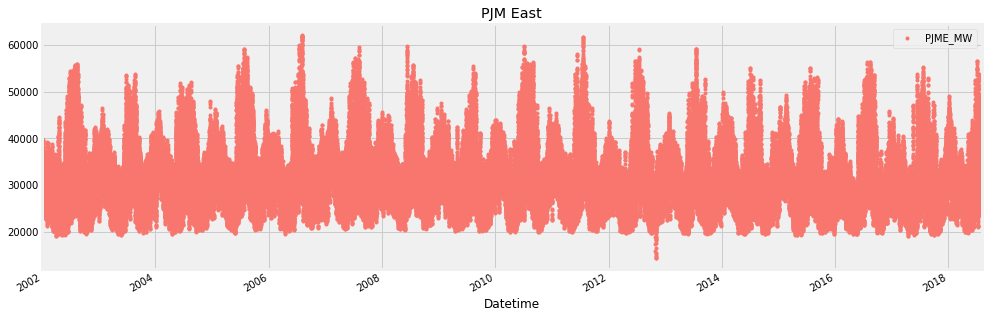

In [5]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

In [6]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

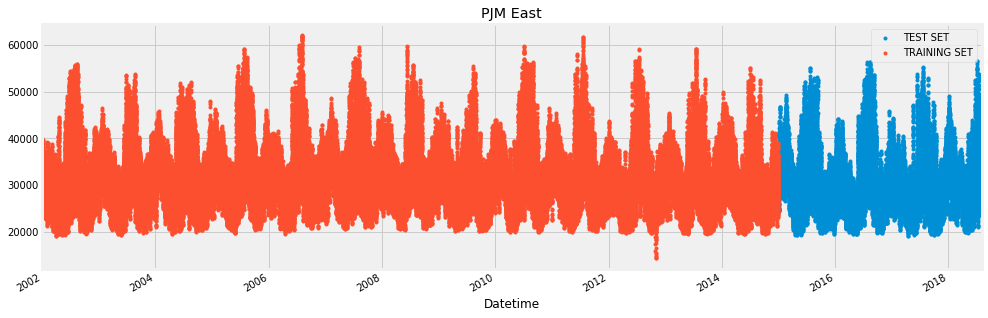

In [7]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Create Features

In [8]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [9]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [10]:
lag_count = 2

X_train, y_train = create_features(pjme_train, lag_count, label='PJME_MW')
X_test, y_test = create_features(pjme_test, lag_count, label='PJME_MW')

In [11]:
print("PJME SHAPE: ", pjme.shape)
print("X_train SHAPE: ", X_train.shape)
print("X_test SHAPE: ", X_test.shape)
print("Dif in rows (expecting lag_count*2): ", pjme.shape[0]-(X_train.shape[0]+X_test.shape[0]))

PJME SHAPE:  (145366, 1)
X_train SHAPE:  (113925, 10)
X_test SHAPE:  (31437, 10)
Dif in rows (expecting lag_count*2):  4


### Create XGBoost Model

In [12]:
start = datetime.datetime.now()
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train
end = datetime.datetime.now()
print("Total runtime for XGBoost: ", end-start)

[15:54:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:29646.8	validation_1-rmse:28782.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:26695	validation_1-rmse:25907.5
[2]	validation_0-rmse:24039	validation_1-rmse:23319.9
[3]	validation_0-rmse:21649.3	validation_1-rmse:20993.5
[4]	validation_0-rmse:19499.5	validation_1-rmse:18900.7
[5]	validation_0-rmse:17565.7	validation_1-rmse:17014.6
[6]	validation_0-rmse:15825.6	validation_1-rmse:15309.4
[7]	validation_0-rmse:14260.5	validation_1-rmse:13781.2
[8]	validation_0-rmse:12853.2	validation_1-rmse:12408.7
[9]	validation_0-rmse:11588	validation_1-rmse:11174
[10]	validation_0-rmse:10449.8	validation_1-rmse:10067
[11]	validation_0-rmse:9426.47	validation_1-rmse:9070.42
[12]	validation_0-rmse:8507.44	validation_1-rmse:8177.72
[13]	validation_0-rmse:7681.78	validation_1-rmse:7374.11
[14]	validation_0-rmse:6939.64	validation_1-rmse:6655.51
[15]	v

[142]	validation_0-rmse:774.354	validation_1-rmse:831.017
[143]	validation_0-rmse:773.614	validation_1-rmse:830.566
[144]	validation_0-rmse:773.152	validation_1-rmse:830.247
[145]	validation_0-rmse:771.57	validation_1-rmse:829.049
[146]	validation_0-rmse:771.251	validation_1-rmse:827.949
[147]	validation_0-rmse:770.632	validation_1-rmse:827.557
[148]	validation_0-rmse:769.973	validation_1-rmse:827.044
[149]	validation_0-rmse:769.193	validation_1-rmse:826.002
[150]	validation_0-rmse:768.873	validation_1-rmse:825.816
[151]	validation_0-rmse:768.408	validation_1-rmse:825.509
[152]	validation_0-rmse:767.516	validation_1-rmse:824.599
[153]	validation_0-rmse:765.89	validation_1-rmse:822.22
[154]	validation_0-rmse:762.54	validation_1-rmse:819.15
[155]	validation_0-rmse:761.979	validation_1-rmse:818.439
[156]	validation_0-rmse:761.693	validation_1-rmse:818.315
[157]	validation_0-rmse:761.51	validation_1-rmse:818.315
[158]	validation_0-rmse:760.985	validation_1-rmse:818.048
[159]	validation_0-r

[284]	validation_0-rmse:698.752	validation_1-rmse:762.951
[285]	validation_0-rmse:698.668	validation_1-rmse:762.942
[286]	validation_0-rmse:698.527	validation_1-rmse:762.851
[287]	validation_0-rmse:697.543	validation_1-rmse:761.541
[288]	validation_0-rmse:696.735	validation_1-rmse:760.922
[289]	validation_0-rmse:696.665	validation_1-rmse:760.915
[290]	validation_0-rmse:696.482	validation_1-rmse:760.733
[291]	validation_0-rmse:696.232	validation_1-rmse:760.592
[292]	validation_0-rmse:695.91	validation_1-rmse:760.336
[293]	validation_0-rmse:695.745	validation_1-rmse:760.222
[294]	validation_0-rmse:695.541	validation_1-rmse:760.152
[295]	validation_0-rmse:695.334	validation_1-rmse:760.042
[296]	validation_0-rmse:695.181	validation_1-rmse:759.967
[297]	validation_0-rmse:694.472	validation_1-rmse:759.492
[298]	validation_0-rmse:694.402	validation_1-rmse:759.449
[299]	validation_0-rmse:694.15	validation_1-rmse:759.312
[300]	validation_0-rmse:693.415	validation_1-rmse:757.906
[301]	validation

[426]	validation_0-rmse:661.125	validation_1-rmse:729.878
[427]	validation_0-rmse:661.008	validation_1-rmse:729.9
[428]	validation_0-rmse:660.912	validation_1-rmse:729.83
[429]	validation_0-rmse:660.751	validation_1-rmse:729.603
[430]	validation_0-rmse:660.445	validation_1-rmse:729.332
[431]	validation_0-rmse:660.154	validation_1-rmse:729.225
[432]	validation_0-rmse:660.034	validation_1-rmse:729.09
[433]	validation_0-rmse:659.72	validation_1-rmse:728.665
[434]	validation_0-rmse:659.511	validation_1-rmse:728.515
[435]	validation_0-rmse:659.326	validation_1-rmse:728.292
[436]	validation_0-rmse:659.218	validation_1-rmse:728.264
[437]	validation_0-rmse:658.825	validation_1-rmse:727.871
[438]	validation_0-rmse:658.702	validation_1-rmse:727.908
[439]	validation_0-rmse:658.504	validation_1-rmse:727.779
[440]	validation_0-rmse:658.454	validation_1-rmse:727.758
[441]	validation_0-rmse:658.37	validation_1-rmse:727.694
[442]	validation_0-rmse:658.3	validation_1-rmse:727.609
[443]	validation_0-rms

[568]	validation_0-rmse:641.604	validation_1-rmse:716.57
[569]	validation_0-rmse:641.577	validation_1-rmse:716.561
[570]	validation_0-rmse:641.498	validation_1-rmse:716.558
[571]	validation_0-rmse:641.33	validation_1-rmse:716.294
[572]	validation_0-rmse:641.179	validation_1-rmse:716.051
[573]	validation_0-rmse:641.008	validation_1-rmse:715.97
[574]	validation_0-rmse:640.959	validation_1-rmse:715.944
[575]	validation_0-rmse:640.792	validation_1-rmse:715.965
[576]	validation_0-rmse:640.627	validation_1-rmse:716.006
[577]	validation_0-rmse:640.543	validation_1-rmse:716.046
[578]	validation_0-rmse:640.501	validation_1-rmse:715.995
[579]	validation_0-rmse:640.288	validation_1-rmse:715.806
[580]	validation_0-rmse:640.228	validation_1-rmse:715.769
[581]	validation_0-rmse:640.167	validation_1-rmse:715.732
[582]	validation_0-rmse:640.08	validation_1-rmse:715.513
[583]	validation_0-rmse:640.034	validation_1-rmse:715.488
[584]	validation_0-rmse:639.99	validation_1-rmse:715.427
[585]	validation_0-

[710]	validation_0-rmse:624.758	validation_1-rmse:705.234
[711]	validation_0-rmse:624.663	validation_1-rmse:705.254
[712]	validation_0-rmse:624.578	validation_1-rmse:705.267
[713]	validation_0-rmse:624.484	validation_1-rmse:705.237
[714]	validation_0-rmse:624.337	validation_1-rmse:705.22
[715]	validation_0-rmse:624.282	validation_1-rmse:705.238
[716]	validation_0-rmse:624.204	validation_1-rmse:705.207
[717]	validation_0-rmse:624.143	validation_1-rmse:705.163
[718]	validation_0-rmse:624.065	validation_1-rmse:705.094
[719]	validation_0-rmse:623.945	validation_1-rmse:705.091
[720]	validation_0-rmse:623.837	validation_1-rmse:704.973
[721]	validation_0-rmse:623.792	validation_1-rmse:704.955
[722]	validation_0-rmse:623.769	validation_1-rmse:704.922
[723]	validation_0-rmse:623.721	validation_1-rmse:704.901
[724]	validation_0-rmse:623.627	validation_1-rmse:704.925
[725]	validation_0-rmse:623.484	validation_1-rmse:704.94
[726]	validation_0-rmse:623.45	validation_1-rmse:704.907
[727]	validation_

[852]	validation_0-rmse:614.021	validation_1-rmse:698.66
[853]	validation_0-rmse:613.969	validation_1-rmse:698.616
[854]	validation_0-rmse:613.808	validation_1-rmse:698.53
[855]	validation_0-rmse:613.755	validation_1-rmse:698.509
[856]	validation_0-rmse:613.69	validation_1-rmse:698.411
[857]	validation_0-rmse:613.66	validation_1-rmse:698.439
[858]	validation_0-rmse:613.609	validation_1-rmse:698.384
[859]	validation_0-rmse:613.498	validation_1-rmse:698.256
[860]	validation_0-rmse:613.437	validation_1-rmse:698.418
[861]	validation_0-rmse:613.404	validation_1-rmse:698.401
[862]	validation_0-rmse:613.346	validation_1-rmse:698.36
[863]	validation_0-rmse:613.334	validation_1-rmse:698.36
[864]	validation_0-rmse:613.272	validation_1-rmse:698.29
[865]	validation_0-rmse:613.238	validation_1-rmse:698.225
[866]	validation_0-rmse:613.167	validation_1-rmse:698.093
[867]	validation_0-rmse:613.063	validation_1-rmse:698.039
[868]	validation_0-rmse:613.014	validation_1-rmse:698.02
[869]	validation_0-rms

[995]	validation_0-rmse:604.389	validation_1-rmse:693.758
[996]	validation_0-rmse:604.354	validation_1-rmse:693.724
[997]	validation_0-rmse:604.313	validation_1-rmse:693.704
[998]	validation_0-rmse:604.295	validation_1-rmse:693.68
[999]	validation_0-rmse:604.252	validation_1-rmse:693.563
Total runtime for XGBoost:  0:01:24.804583


### Feature Importance

Feature importance is a measure of how many times a feature is split up on.

Dayofyear is most commonly used to split trees, hour and year are next most common. Quarter has low importance as it is a function of dayofyear.

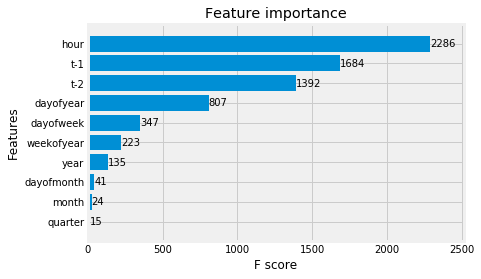

In [13]:
plot_importance(reg, height=.8)

### Forecast on Test Set

In [14]:
# Drop first ten rows of test set because X currently drops 10 rows **FIX THIS**
pjme_test = pjme_test[lag_count:]

In [15]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

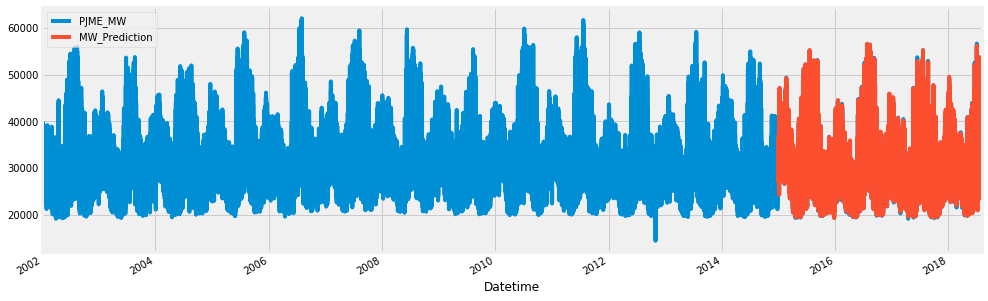

In [16]:
temp_plot = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### A look at the first month of predictions

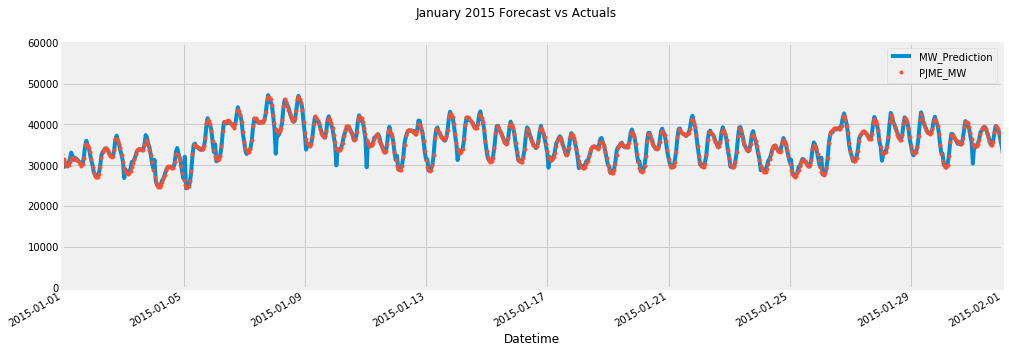

In [17]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_chart = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### A look at the first week of predictions

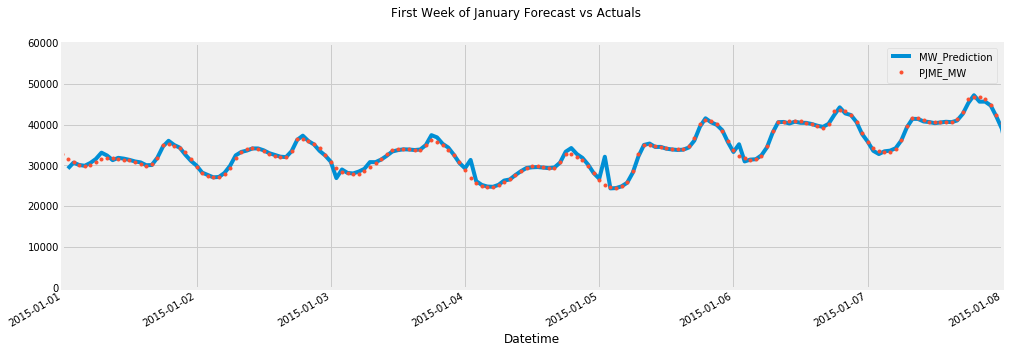

In [18]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

### A look at the another week of predictions

This time, we take a look at the first week of July

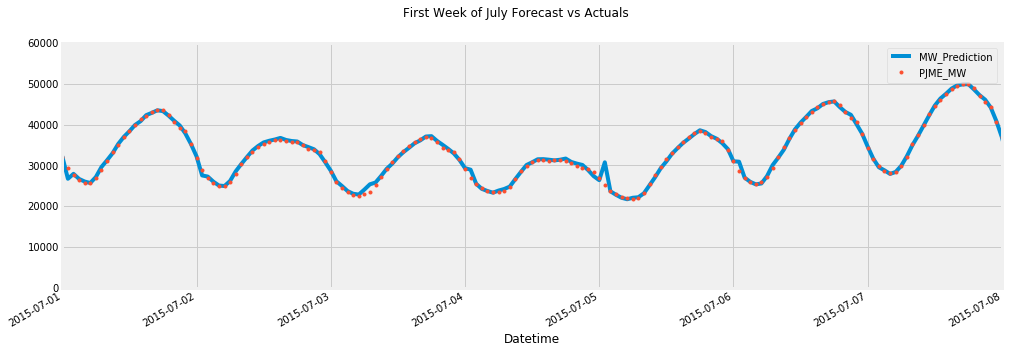

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Plotting Residuals

In [20]:
pjme_all['error'] = pjme_all['MW_Prediction'] - pjme_all['PJME_MW']

In [21]:
pjme_test['error'] = pjme_test['MW_Prediction'] - pjme_test['PJME_MW']

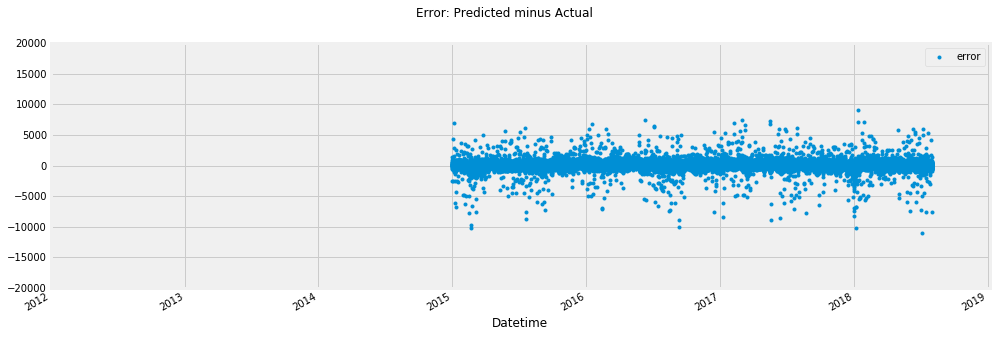

In [22]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_all[['error']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='01-01-2012', upper='01-08-2019')
ax.set_ylim(-20000, 20000)
plot = plt.suptitle('Error: Predicted minus Actual')

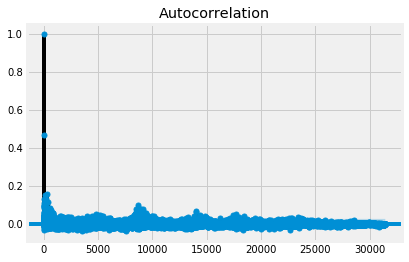

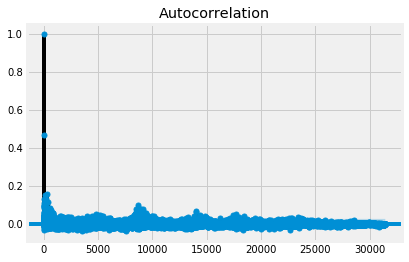

In [23]:
# Plotting Autocorrelation
# Autocorrelation = 1 is perfect correlation
from statsmodels.graphics.tsaplots import plot_acf
series = pjme_test['error']
plot_acf(series)

### Durbin Watson Test

In [24]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error'])

1.7310954181481235

In [25]:
pjme_test['error'][0]

154.224609375

In [26]:
top = 0
bot = 0

for i in range(1, len(pjme_test['error'])):
    temp_top = (pjme_test['error'][i] - pjme_test['error'][i-1])**2
    temp_bot = pjme_test['error'][i]**2
    
    top += temp_top
    bot += temp_bot
    
print("TOP: ", top)
print("BOT: ", bot)
print("DW: ", top/bot)

TOP:  26177979964.58907
BOT:  15122181316.89735
DW:  1.7310981409367243


### Error Metrics on Test Set

Error metrics looked at:
* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* MAPE (Mean Absolute Percentage Error)

In [27]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
# Evaluate
i = 'MW_Prediction'
print("MSE: ", mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i])))
print("MAE: ", mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['PJME_MW'], pjme_test[i]), 4)))
print("\n")

MSE:  481032.0673768962
RMSE:  693.5647535572264
MAE:  374.8123804652957
Mean Absolute Percentage Error: 1.2352%




### Worst vs Best Predicted Days

In [29]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
pjme_test['abs_error_pct'] = pjme_test['abs_error']/pjme_test['PJME_MW']*100
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error', 'abs_error_pct']]

In [30]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error  \
year month dayofmonth                                                        
2018 1     12          29211.041667   29833.291016 -622.248617  671.029704   
2017 3     1           27574.125000   28186.498047 -612.372803  638.904053   
2016 3     25          25174.416667   25777.433594 -603.017090  608.068522   
2017 2     8           28523.833333   29107.468750 -583.636230  642.318034   
           24          26445.083333   27005.312500 -560.228923  659.351807   
2018 2     21          27572.500000   28125.794922 -553.295573  646.736003   
2015 11    27          25509.750000   26027.755859 -518.005859  544.840820   
2017 2     20          27070.583333   27575.234375 -504.652018  531.272135   
     3     2           28309.083333   28796.826172 -487.743164  616.324056   
2016 6     10          27941.583333   28429.271484 -487.687581  628.192790   

                       abs_error_pct  
year month dayofmonth                 
2018 1     12               2.438463  
2017 3     1                2.475686  
2016 3     25               2.496847  
2017 2     8                2.380147  
           24               2.595591  
2018 2     21               2.466416  
2015 11    27               2.127240  
2017 2     20               2.091268  
     3     2                2.460209  
2016 6     10               2.430216

As noted in the notebook: 
* Some of the worst misses were holidays, so a holiday indicator could be beneficial

In [31]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction        error    abs_error  \
year month dayofmonth                                                          
2018 1     1           40191.041667   38899.167969  1291.874105  1373.653076   
           2           41627.333333   40493.886719  1133.445231  1192.185465   
           7           42159.708333   41253.613281   906.094238  1101.354655   
2015 2     20          44694.041667   43878.187500   815.855550  1073.818115   
2017 5     19          38032.583333   37357.917969   674.664795   893.463460   
2015 2     24          41002.166667   40548.605469   453.562500   884.872721   
2017 12    31          39016.000000   38199.125000   816.875163   840.759928   
2018 7     6           39145.250000   38875.222656   270.026367   822.686523   
     1     6           43565.750000   42821.703125   744.047038   820.646322   
2015 2     16          43949.500000   43312.492188   637.009115   804.748372   

                       abs_error_pct  
year month dayofmonth                 
2018 1     1                3.482595  
           2                2.952855  
           7                2.631483  
2015 2     20               2.477593  
2017 5     19               2.540152  
2015 2     24               2.211574  
2017 12    31               2.280118  
2018 7     6                2.167168  
     1     6                1.923911  
2015 2     16               1.906752

In [32]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error  \
year month dayofmonth                                                        
2018 5     17          28035.208333   28051.703125  -16.494548  122.271077   
2017 4     22          24219.083333   24205.121094   13.961833  133.606852   
2016 10    1           24848.416667   24872.021484  -23.604411  138.613200   
     4     23          24050.583333   24047.000000    3.582845  139.259766   
     3     4           33230.166667   33243.273438  -13.105306  140.631185   
2017 5     13          24752.333333   24733.537109   18.797038  140.978516   
2016 5     21          23928.916667   24039.349609 -110.433268  142.325033   
2015 10    3           25534.875000   25522.009766   12.866048  143.454590   
2016 4     29          27014.291667   27044.837891  -30.545980  150.276286   
     5     3           26982.041667   27072.179688  -90.138102  150.549235   

                       abs_error_pct  
year month dayofmonth                 
2018 5     17               0.450059  
2017 4     22               0.538892  
2016 10    1                0.568492  
     4     23               0.570705  
     3     4                0.432484  
2017 5     13               0.587931  
2016 5     21               0.592299  
2015 10    3                0.548094  
2016 4     29               0.562505  
     5     3                0.580026

### Plotting Worst Predicted Days

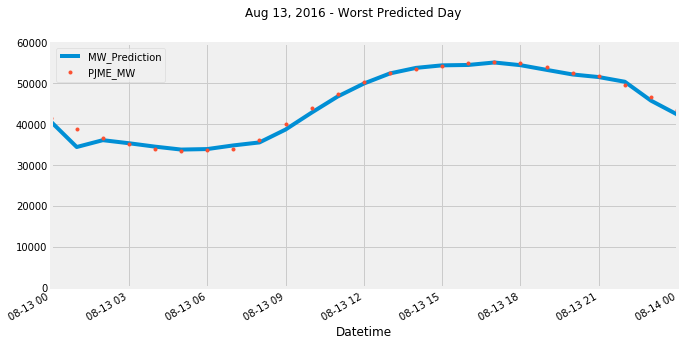

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

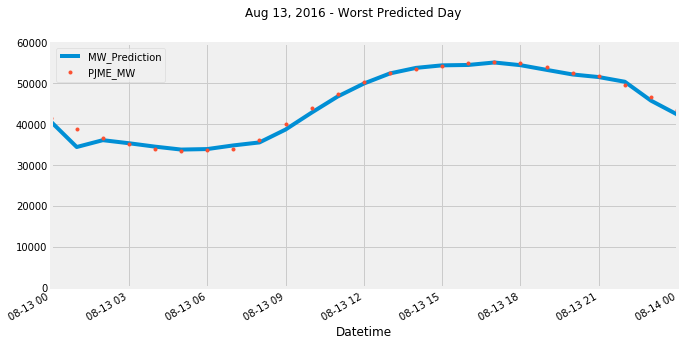

In [34]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

### Plotting Best Predicted Days

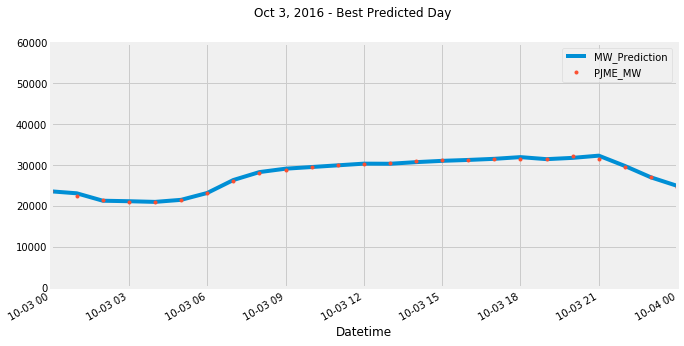

In [35]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

## Nested Cross-Validation

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

K-Fold Cross Validation is the gold standard for validating ML algorithms. However, K-Fold Cross Validation does not work with time-series, as it fails to capture temporal dependencies. Instead, we'll use nested cross validation.

In [36]:
start_dates = [
    '01-JAN-2002',
    '01-JAN-2003',
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011', 
    '01-JAN-2012' 
]

split_dates = [
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016', 
    '01-JAN-2017' 
]

end_dates = [
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016',
    '01-JAN-2017', 
    '01-JAN-2018' 
]

start date:  01-JAN-2002
split date:  01-JAN-2007
end date:  01-JAN-2008 

start date:  01-JAN-2003
split date:  01-JAN-2008
end date:  01-JAN-2009 

start date:  01-JAN-2004
split date:  01-JAN-2009
end date:  01-JAN-2010 

start date:  01-JAN-2005
split date:  01-JAN-2010
end date:  01-JAN-2011 

start date:  01-JAN-2006
split date:  01-JAN-2011
end date:  01-JAN-2012 

start date:  01-JAN-2007
split date:  01-JAN-2012
end date:  01-JAN-2013 

start date:  01-JAN-2008
split date:  01-JAN-2013
end date:  01-JAN-2014 

start date:  01-JAN-2009
split date:  01-JAN-2014
end date:  01-JAN-2015 

start date:  01-JAN-2010
split date:  01-JAN-2015
end date:  01-JAN-2016 

start date:  01-JAN-2011
split date:  01-JAN-2016
end date:  01-JAN-2017 

start date:  01-JAN-2012
split date:  01-JAN-2017
end date:  01-JAN-2018 



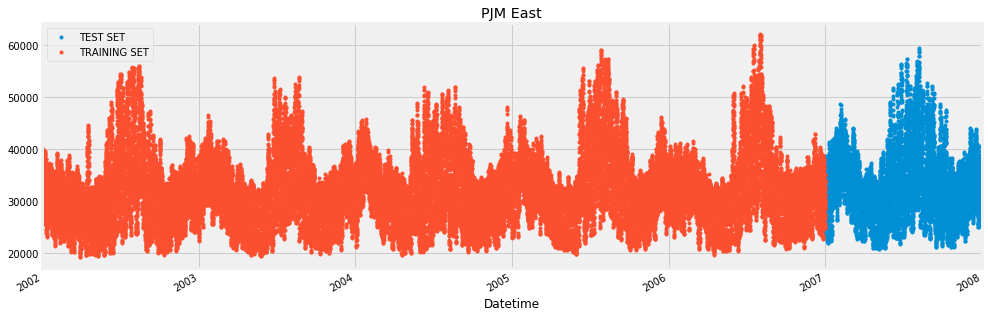

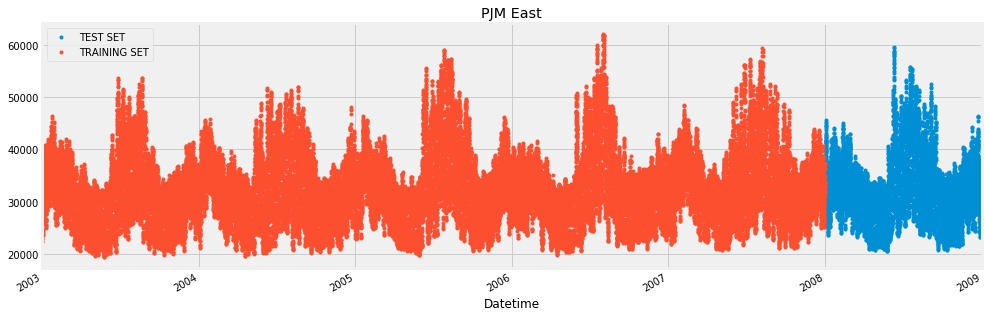

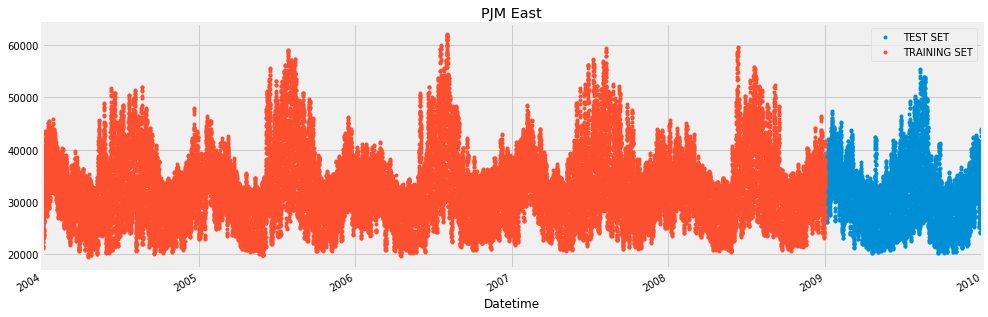

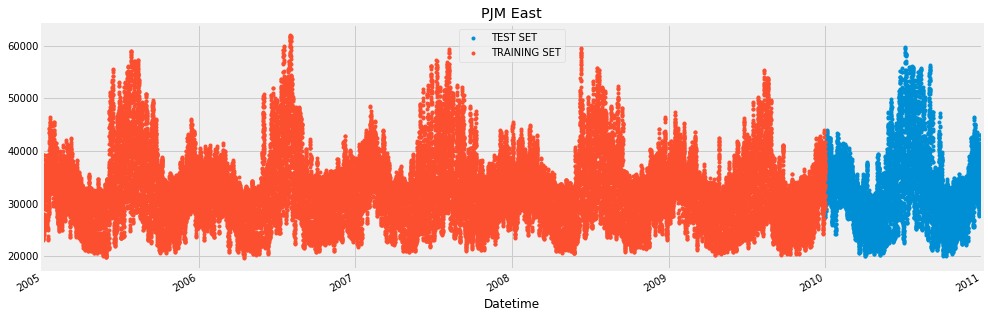

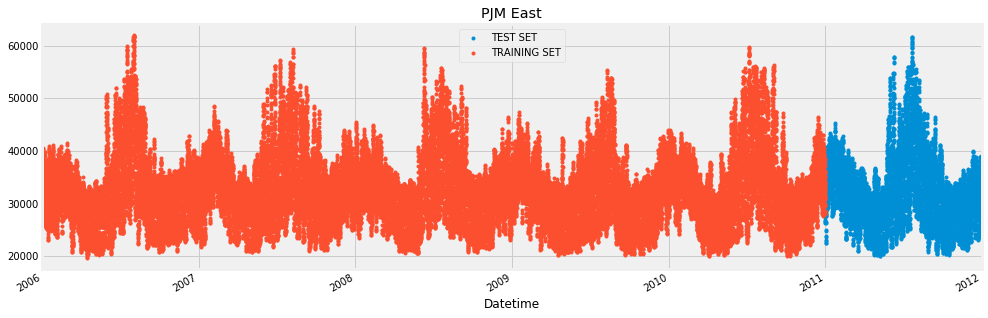

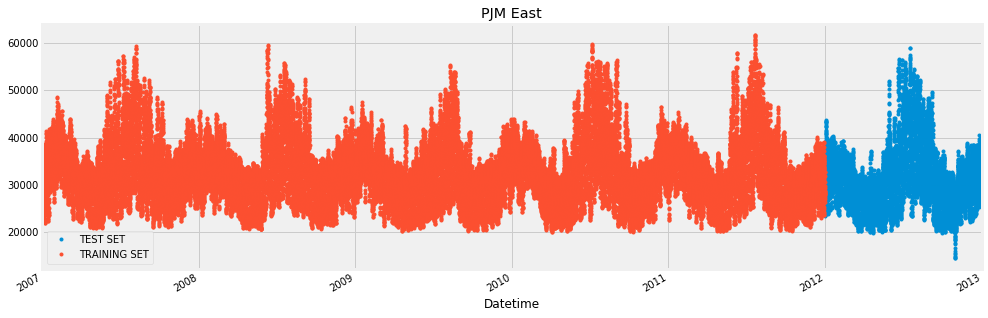

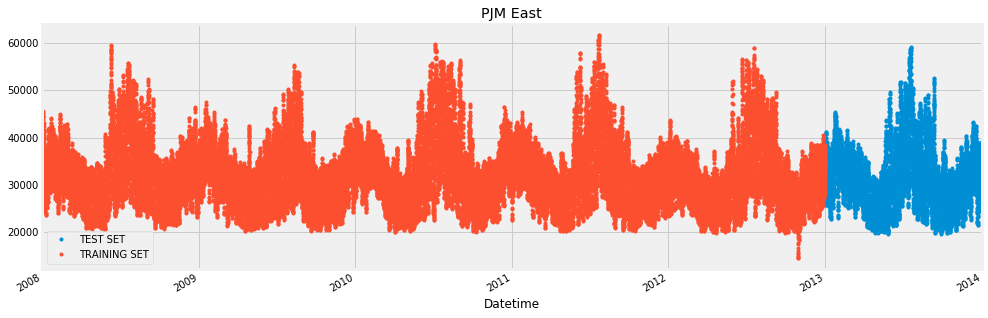

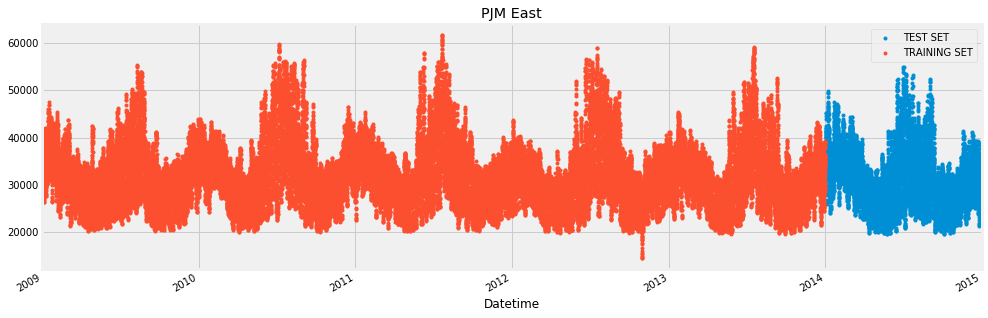

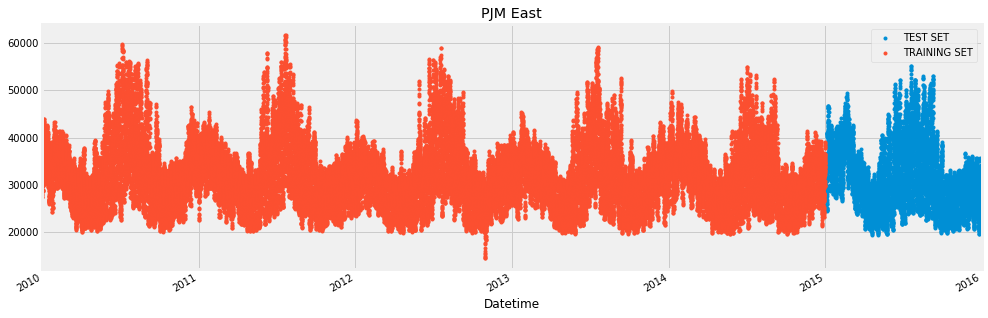

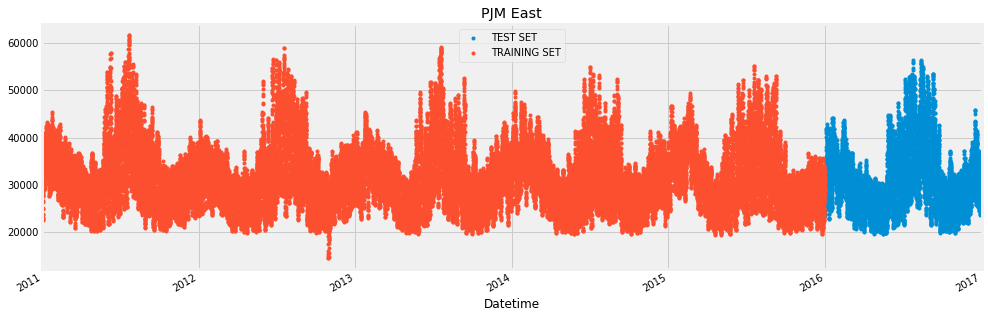

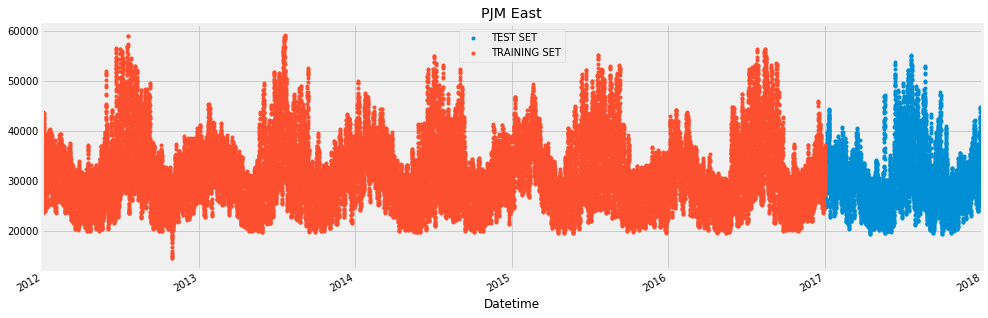

In [37]:
for i in range(0, len(split_dates)):
    print('start date: ', start_dates[i])
    print('split date: ', split_dates[i])
    print('end date: ', end_dates[i], '\n')
    temp_pjme_train = pjme.loc[pjme.index <= split_dates[i]].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_dates[i]].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_dates[i]].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_dates[i]].copy()
    
    temp_plot = nested_pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(nested_pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [49]:
def nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count):
    # Because the data is a time-series, k-fold cross-validation is not sufficient.
    # Instead, we will use nested cross-validation
    
    for i in range(0, len(split_dates)):
        temp_start_date = start_dates[i]
        temp_split_date = split_dates[i]
        temp_end_date = end_dates[i]
        
        print('start date: ', temp_start_date)
        print('split date: ', temp_split_date)
        print('end date: ', temp_end_date, '\n')
        
        nested_pjme_train, nested_pjme_test = get_nested_train_test(temp_start_date, temp_split_date, temp_end_date, pjme)
        
        X_train, y_train = create_features(nested_pjme_train, lag_count, label='PJME_MW')
        X_test, y_test = create_features(nested_pjme_test, lag_count, label='PJME_MW')
        
        nested_pjme_test = nested_pjme_test[lag_count:]
    
        reg = train_model(X_train, y_train, X_test, y_test)
        
        nested_pjme_test['MW_Prediction'] = reg.predict(X_test)
        
        # Evaluate
        print("MSE: ", mean_squared_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction']))
        print("RMSE: ", math.sqrt(mean_squared_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction'])))
        print("MAE: ", mean_absolute_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction']))
        print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(nested_pjme_test['PJME_MW'], nested_pjme_test['MW_Prediction']), 4)))
        print("\n")
        print("================")
     

In [50]:
def get_nested_train_test(start_date, split_date, end_date, pjme):
    temp_pjme_train = pjme.loc[pjme.index <= split_date].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_date].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_date].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_date].copy()
    
    return nested_pjme_train, nested_pjme_test

In [51]:
def train_model(X_train, y_train, X_test, y_test):
    start = datetime.datetime.now()
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    end = datetime.datetime.now()
    print("Total runtime for XGBoost: ", end-start)
    
    return reg

In [52]:
nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count)

start date:  01-JAN-2002
split date:  01-JAN-2007
end date:  01-JAN-2008 

[16:14:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:22.532700
MSE:  503345.5095748788
RMSE:  709.4684697538565
MAE:  408.80329307982186
Mean Absolute Percentage Error: 1.2549%


start date:  01-JAN-2003
split date:  01-JAN-2008
end date:  01-JAN-2009 



C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:14:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:13.046106
MSE:  430310.9558468323
RMSE:  655.9809111908916
MAE:  407.3658166869519
Mean Absolute Percentage Error: 1.2652%


start date:  01-JAN-2004
split date:  01-JAN-2009
end date:  01-JAN-2010 

[16:14:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:12.087669
MSE:  424414.2514940379
RMSE:  651.4708370249875
MAE:  410.2096492448898
Mean Absolute Percentage Error: 1.3177%


start date:  01-JAN-2005
split date:  01-JAN-2010
end date:  01-JAN-2011 

[16:15:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Total runtime for XGBoost:  0:00:29.441257
MSE:  479046.1559559908
RMSE:  692.1316030611453
MAE:  379.26112384543455
Mean Absolute Percentage Error: 1.1677%


start date:  01-JAN-2006
split date:  01-JAN-2011
end date:  01-JAN-2012 

[16:15:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:31.430932
MSE:  386581.49073847744
RMSE:  621.7567777985837
MAE:  355.9644737335132
Mean Absolute Percentage Error: 1.1264%


start date:  01-JAN-2007
split date:  01-JAN-2012
end date:  01-JAN-2013 

[16:16:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:30.092513
MSE:  444543.0580373911
RMSE:  666.7406227592489
MAE:  379.6100883210198
Mean Absolute Percentage Error: 1.2781%


start date:  01-JAN-2008
split date:  01-JAN-2013
end date:  01-JAN-2014 

[16:16:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:30.352784
MSE:  435785.49488634366
RMSE:  660.1405114718712
MAE:  368.6851884563778
Mean Absolute Percentage Error: 1.1999%


start date:  01-JAN-2009
split date:  01-JAN-2014
end date:  01-JAN-2015 

[16:17:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:20.180059
MSE:  496963.8370739322
RMSE:  704.9566207036659
MAE:  392.79610258020324
Mean Absolute Percentage Error: 1.2711%


start date:  01-JAN-2010
split date:  01-JAN-2015
end date:  01-JAN-2016 



C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:17:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:31.125718
MSE:  448082.0709883412
RMSE:  669.3893269154664
MAE:  374.6591934010732
Mean Absolute Percentage Error: 1.2187%


start date:  01-JAN-2011
split date:  01-JAN-2016
end date:  01-JAN-2017 

[16:18:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:29.614790
MSE:  442700.1164059027
RMSE:  665.3571344818531
MAE:  364.7106924420756
Mean Absolute Percentage Error: 1.2025%


start date:  01-JAN-2012
split date:  01-JAN-2017
end date:  01-JAN-2018 

[16:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:26.747623
MSE:  452968.02857362165
RMSE:  673.0289953439017
MAE:  368.8282186536705
Mean Absolute Percentage Error: 1.2389%




### Conclusion

The algorithm seems to have predictive power. 

Summary statistics for nested cross-validation are in line with those of the overall model, suggesting generalizability.

#### RMSE
* Overall: 693.56
* Maximum: 709.46
* Minimum: 621.75

#### Mean Absolute Percentage Error
* Overall: 1.23%
* Maximum: 1.31%
* Minimum: 1.12%

Additionally, the **DW Statistic** for the overall model is near two at 1.73, suggesting little autocorrelation of residuals.

